<font color='blue'>
# Kaggle房價預測    
<br>
 https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

## Read_CSV files

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('train: ',train.shape)
print('test: ',test.shape)

train:  (1460, 81)
test:  (1459, 80)


## EDA

### values of column SalePrice

Text(360000,4.5e-06,'           SalePrice\ncount    1460.000000\nmean   180921.195890\nstd     79442.502883\nmin     34900.000000\n25%    129975.000000\n50%    163000.000000\n75%    214000.000000\nmax    755000.000000')

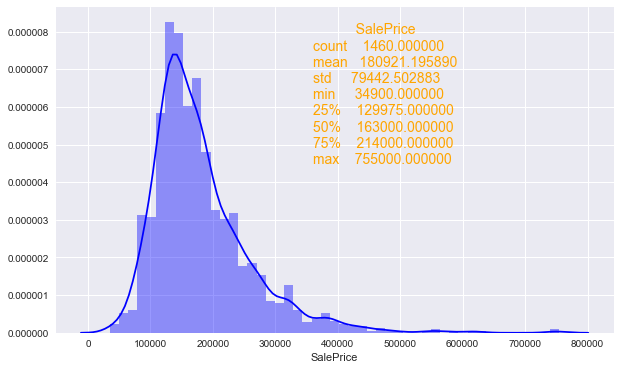

In [4]:
fig = plt.figure(1,(10,6))
sns.distplot(train['SalePrice'],color = 'blue');
target_describe = pd.DataFrame(train['SalePrice']).describe()
plt.text(360000,0.0000045,target_describe,fontsize=14,color='orange')

## Data cleaning

### Drop Column: Id

In [5]:
train = train.iloc[:,1:]
test = test.iloc[:,1:]

print('train: ',train.shape)
print('test: ',test.shape)

train:  (1460, 80)
test:  (1459, 79)


### Extract Numerical Features

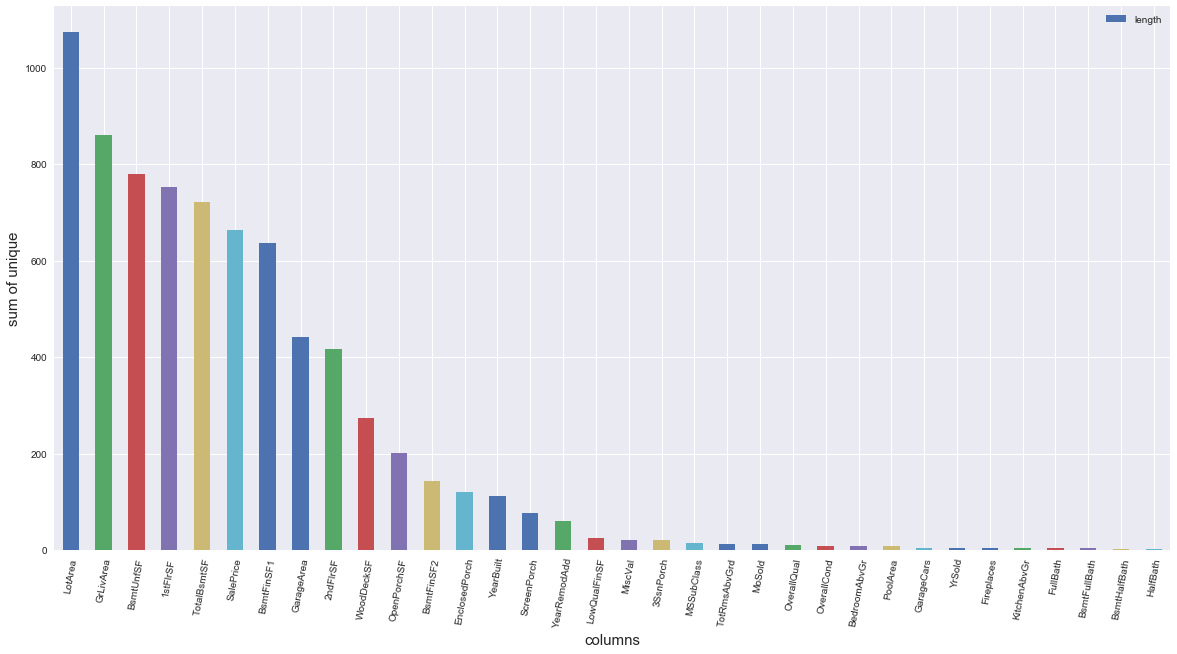

numerical columns:  ['LotFrontage' 'MasVnrArea' 'GarageYrBlt' 'LotArea' 'GrLivArea'
 'BsmtUnfSF' '1stFlrSF' 'TotalBsmtSF' 'SalePrice' 'BsmtFinSF1'
 'GarageArea' '2ndFlrSF' 'WoodDeckSF' 'OpenPorchSF' 'BsmtFinSF2'
 'EnclosedPorch' 'YearBuilt' 'ScreenPorch' 'YearRemodAdd' 'LowQualFinSF'
 'MiscVal' '3SsnPorch'] 
length:  22 columns


In [6]:
#column type: float64
train_type = train.dtypes
float_cols = pd.Series(train_type[train_type=='float64'])
# column type: int64
int_cols = pd.Series(train_type[train_type=='int64'])
int_cols_len = [len(set(train[i])) for i in int_cols.index]
df_int_cols_len = pd.DataFrame({'cols':int_cols.index,'length':int_cols_len})
df_int_cols_len = df_int_cols_len.sort_values('length',ascending=False) # sort by 'length'

df_int_cols_len.plot('cols','length',kind='bar',rot=80,figsize=(20,10))
plt.xlabel('columns',fontsize=15)
plt.ylabel('sum of unique',fontsize=15)
plt.show()

# if length > 15, it is numerical features
numeric_cols_int = df_int_cols_len[df_int_cols_len['length']>15]
numeric_cols_int = numeric_cols_int['cols']
numeric_cols = pd.Series(np.hstack((float_cols.index,numeric_cols_int)))

print('numerical columns: ',numeric_cols.values,'\nlength: ',len(numeric_cols),'columns')

### Drop Outliers_step1 

According to GrLivArea

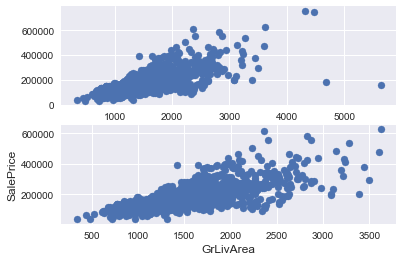

In [7]:
fig,ax = plt.subplots(2)
ax[0].scatter(train['GrLivArea'],train['SalePrice'])

train.drop(train[train['GrLivArea']>4000].index,inplace=True)
train.reset_index(drop=True,inplace=True)

ax[1].scatter(train['GrLivArea'],train['SalePrice'])
plt.ylabel('SalePrice',fontsize=12)
plt.xlabel('GrLivArea',fontsize=12)
plt.show()

### Drop Outliers_step2

According to Tukey's Test

In [8]:
def tukey(data,tukey_list,k=3):
    tukey_data = pd.DataFrame()
    for col in tukey_list:
        q1 = np.percentile(data[col].values,25)
        q3 = np.percentile(data[col].values,75)
        IQR = q3 - q1
        min_data = q1 - k*IQR
        max_data = q3 + k*IQR
        tukey_data[col] = data[col].clip(min_data,max_data)
    return tukey_data

In [9]:
train[numeric_cols] = tukey(train,numeric_cols,k=3)
train.shape

(1456, 80)

### Check duplicate values of every column

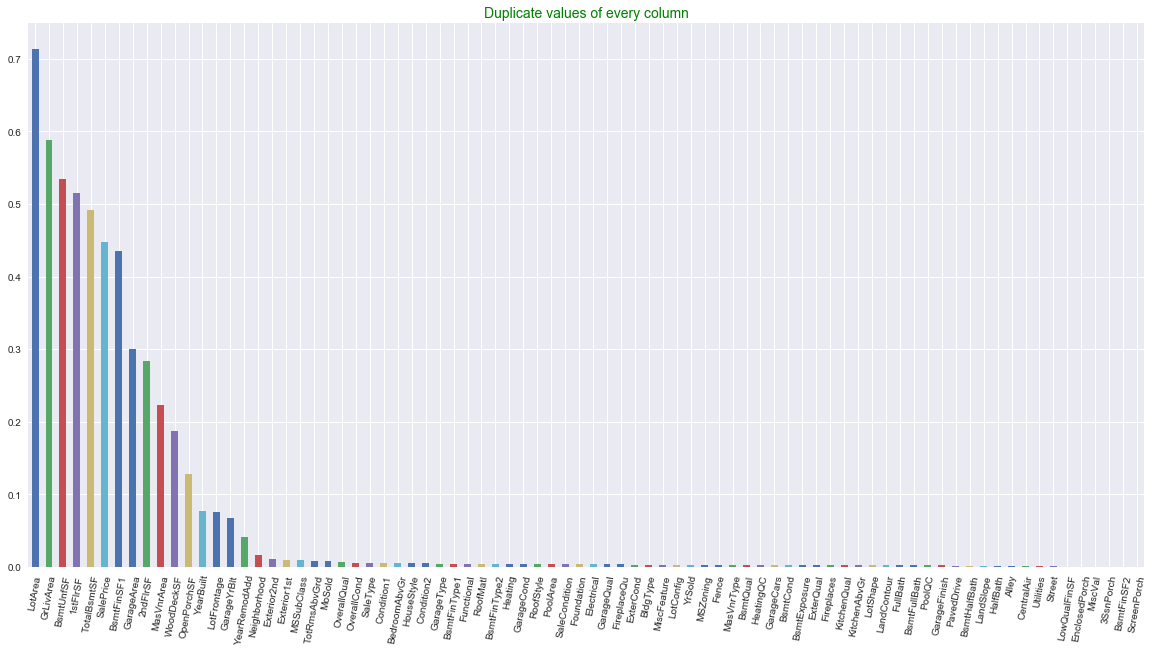

In [10]:
fig = plt.figure(2,figsize = (20,10))
duplicate_train = train.apply(lambda x: x.unique().shape[0]/train.shape[0])
duplicate_train.sort_values(ascending=False).plot(kind = 'bar',rot=80)
plt.title('Duplicate values of every column',fontsize = 14,color = 'green')
plt.show()

### Handling missing data_step1

Check counts of missing data

counts of train missing data:  19 columns
counts of test missing data:  33 columns


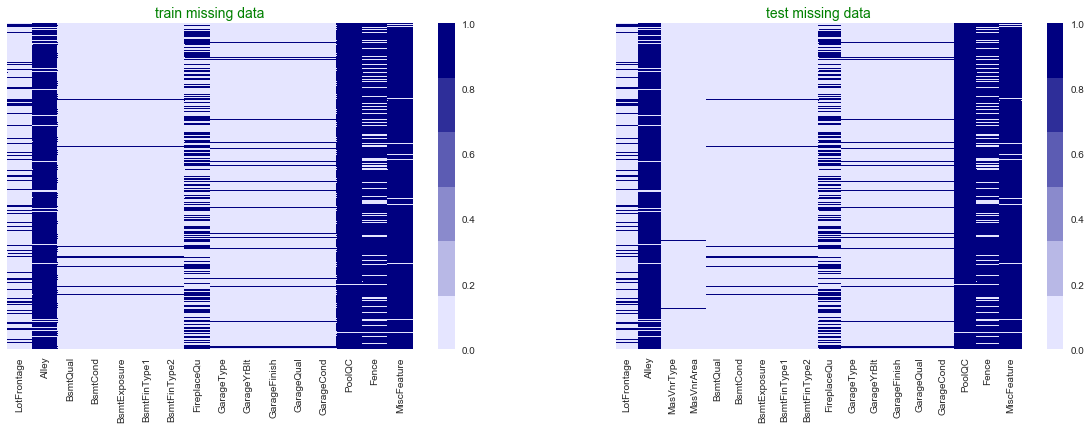

In [11]:
print('counts of train missing data: ',train.isnull().any().sum(),'columns')
print('counts of test missing data: ',test.isnull().any().sum(),'columns')

plt.figure(12,figsize = (20,6))
cmap=sns.light_palette("navy", reverse=False)

plt.subplot(121)
train_more_null = train[train.columns[train.isnull().sum() > 10]]
sns.heatmap(train_more_null.isnull().astype(np.int8),yticklabels=False,cmap=cmap)
plt.title('train missing data',fontsize = 14,color='green')

plt.subplot(122)
test_more_null = train[test.columns[test.isnull().sum() > 10]]
sns.heatmap(test_more_null.isnull().astype(np.int8),yticklabels=False,cmap=cmap)
plt.title('test missing data',fontsize = 14,color='green')
plt.show()

### Handling missing data_step2

Drop columns if missing data more than 40%

In [12]:
drop_cols_list_mask = (train.isnull().sum() / len(train['SalePrice'])) > 0.4
drop_cols_list = train.columns[drop_cols_list_mask]
print('drop 5 columns: ',drop_cols_list.values)

train = train.drop(drop_cols_list,axis=1) 
test = test.drop(drop_cols_list,axis=1)

drop 5 columns:  ['Alley' 'FireplaceQu' 'PoolQC' 'Fence' 'MiscFeature']


### Handling missing data_step3

Filling in missing data

In [13]:
from sklearn.preprocessing import Imputer

null_cols_list = train.columns[train.isnull().any().values]
null_cols_list_test = test.columns[test.isnull().any().values]
print('numerical columns that filling in: \n',null_cols_list)

# numerical columns(train and test): filling in the mean value
imp_numeric = Imputer(strategy='mean') 
train[numeric_cols] = imp_numeric.fit_transform(train[numeric_cols])
numeric_cols_test = np.hstack((numeric_cols[0:8], numeric_cols[9:]))
test[numeric_cols_test] = imp_numeric.fit_transform(test[numeric_cols_test])

numerical columns that filling in: 
 Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')


In [14]:
# other columns (train and test): filling in the most common value
# train
for i in range(len(null_cols_list)): 
    col = train[null_cols_list].columns[i] # null columns
    train[col] = train[col].replace(['None'],np.nan) # None replace nan
    unique1 =  train[col].unique()[0] # unique value
    train[col] = train[col].fillna(unique1) # random fill in
    train[col] = train[col].fillna(train[col].mode()) # fill in the most common value
# test
for i in range(len(null_cols_list_test)):
    col = test[null_cols_list_test].columns[i]
    test[col] = test[col].replace(['None'],np.nan)
    unique1 =  test[col].unique()[0] 
    test[col] = test[col].fillna(unique1) 
    test[col] = test[col].fillna(test[col].mode()) 
test['MasVnrType'] = test['MasVnrType'].fillna('BrkFace')

### Handling missing data_step4

Check remaining missing value

In [15]:
assert train[null_cols_list].isnull().any().sum() == 0, 'Error train還有空值'
assert test[null_cols_list_test].isnull().any().sum() == 0, 'Error test還有空值'

print('counts of train missing data: ',train.isnull().any().sum(),'columns')
print('counts of test missing data: ',test.isnull().any().sum(),'columns')

counts of train missing data:  0 columns
counts of test missing data:  0 columns


## Features Engineering

### One hot encoding

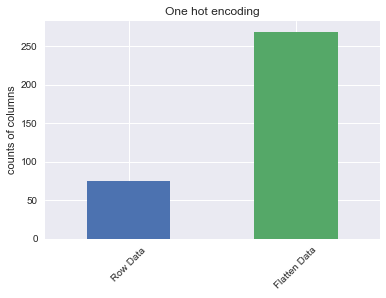

In [16]:
train_dums = pd.get_dummies(train)
test_dums = pd.get_dummies(test)

y = train_dums.shape[1] # 270 columns
x = train.shape[1] # 75 columns
pd.Series([x,y],index=['Row Data','Flatten Data'])\
    .plot(kind='bar',rot=45)
plt.title('One hot encoding')
plt.ylabel('counts of columns')
plt.show()

###  Feature selection according to correlation

In [17]:
# columns of correlation >0.5 or <-0.5 
corr_train = train_dums.corr() 
corr_train_cols1 = corr_train['SalePrice'][corr_train['SalePrice'].values > 0.5].index # correlation > 0.5: 13 columns
corr_train_cols2 = corr_train['SalePrice'][corr_train['SalePrice'].values < -0.5].index #correlation < -0.5: 2 columns
corr_train_cols = np.hstack((corr_train_cols1,corr_train_cols2))

<Figure size 432x288 with 0 Axes>

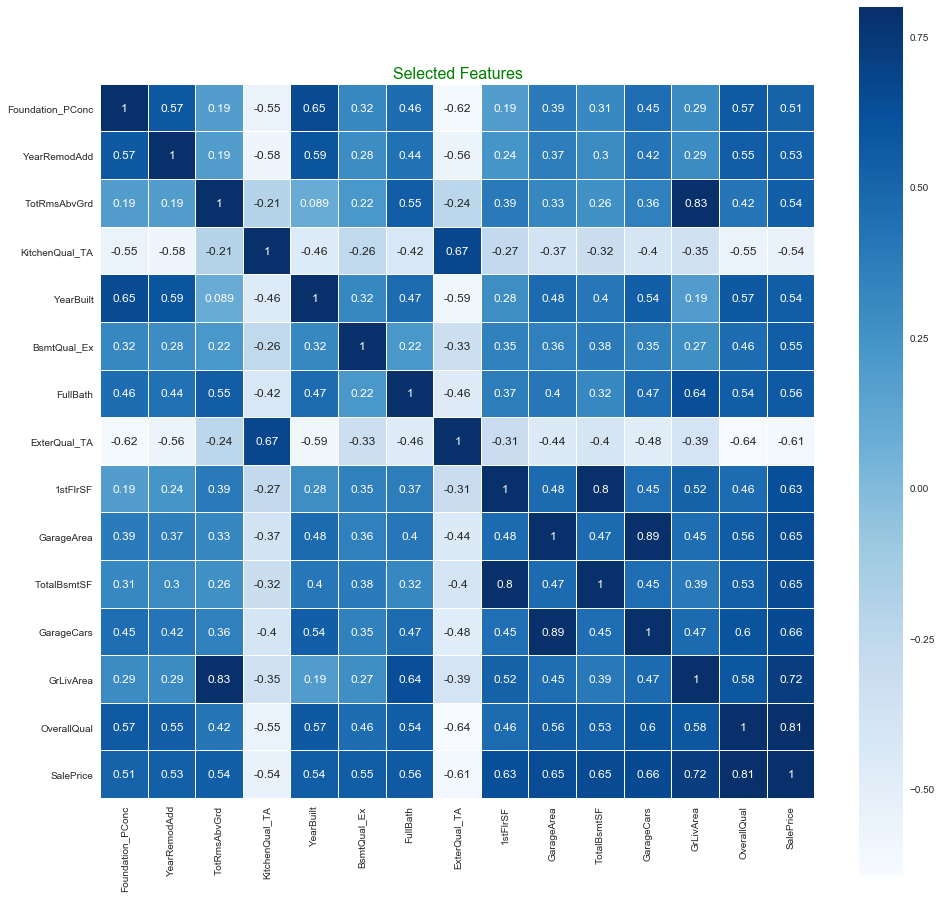

In [18]:
# correlation heatmap
train_dums_corr = train_dums[corr_train_cols]
corr_train_cols_sorted = train_dums_corr.corr()['SalePrice'].apply(lambda x: np.abs(x)).sort_values(ascending=True) # sort and save as series
train_dums_corr = train_dums[corr_train_cols_sorted.index] # train:correlated and sorted DataFrame

corr_train_cols_sorted_test = corr_train_cols_sorted[0:-1]
test_dums_corr = test_dums[corr_train_cols_sorted_test.index] # test:correlated and sorted DataFrame

plt.figure(1)
plt.subplots(figsize=(16,16))
sns.heatmap(train_dums_corr.corr(),vmax=.8,linewidths=0.01, cmap='Blues',annot=True,square = True)
plt.title('Selected Features',fontsize=16,color = 'green')
plt.show()

<Figure size 1440x720 with 0 Axes>

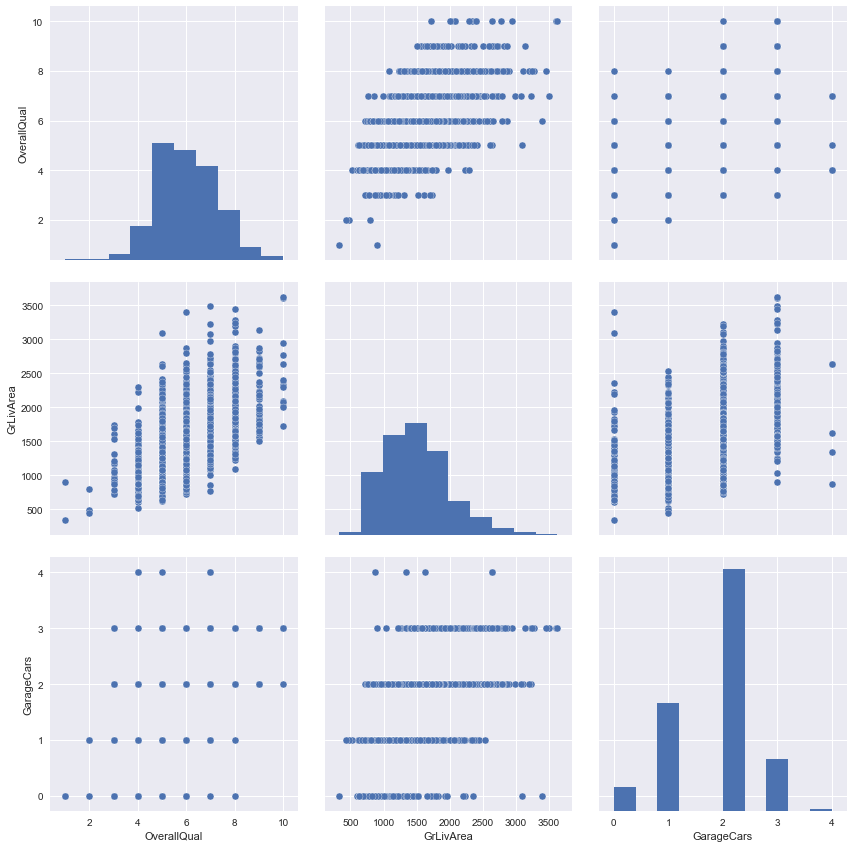

In [19]:
# pairplot of Top 3 features 
plt.figure(3,figsize = (20,10))
sns.pairplot(data=train_dums_corr,vars=['OverallQual', 'GrLivArea', 'GarageCars'],size = 4)
plt.show()

## Data standardization

In [21]:
# train
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp = train_dums.drop('SalePrice',axis=1)

for i in range(len(temp.columns)):
    temp.iloc[:,i] = scaler.fit_transform(temp.iloc[:,i].values.reshape(-1,1))
train_dums = pd.concat([temp,train_dums['SalePrice']],axis=1)
train_dums.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.073476,-0.224620,-0.333224,0.665646,-0.517461,1.053769,0.880629,0.531208,0.625446,0.0,...,-0.2997,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,208500.0
1,-0.871172,0.493259,-0.053392,-0.064709,2.176545,0.159469,-0.427190,-0.577452,1.257846,0.0,...,-0.2997,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,181500.0
2,0.073476,-0.081044,0.348106,0.665646,-0.517461,0.987524,0.832191,0.338890,0.113946,0.0,...,-0.2997,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,223500.0
3,0.309638,-0.463912,-0.065559,0.665646,-0.517461,-1.860986,-0.717817,-0.577452,-0.513805,0.0,...,-0.2997,-0.045439,0.388572,3.682391,-0.052486,-0.091161,-0.118015,-2.149796,-0.303765,140000.0
4,0.073476,0.684694,1.080537,1.396000,-0.517461,0.954402,0.735316,1.402298,0.506871,0.0,...,-0.2997,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,250000.0


In [22]:
# test
scaler = StandardScaler()
for i in range(len(test_dums.columns)):
    test_dums.iloc[:,i] = scaler.fit_transform(test_dums.iloc[:,i].values.reshape(-1,1))   
test_dums.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.874711,0.555587,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.570108,0.063295,0.517348,...,-0.045392,-0.295268,-0.052432,0.398568,-0.254879,-0.074253,-0.091066,-0.134699,0.460211,-0.299365
1,-0.874711,0.604239,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.041273,1.063392,-0.297903,...,-0.045392,-0.295268,-0.052432,0.398568,-0.254879,-0.074253,-0.091066,-0.134699,0.460211,-0.299365
2,0.061351,0.263676,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.570108,0.773254,-0.297903,...,-0.045392,-0.295268,-0.052432,0.398568,-0.254879,-0.074253,-0.091066,-0.134699,0.460211,-0.299365
3,0.061351,0.458284,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.456889,0.357829,-0.297903,...,-0.045392,-0.295268,-0.052432,0.398568,-0.254879,-0.074253,-0.091066,-0.134699,0.460211,-0.299365
4,1.465443,-1.244533,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.570108,-0.387298,-0.297903,...,-0.045392,-0.295268,-0.052432,0.398568,-0.254879,-0.074253,-0.091066,-0.134699,0.460211,-0.299365


## Modeling

### Import libraries

In [23]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import math
import sklearn.metrics as sklm
import xgboost as xgb

### Define X and Y

In [24]:
trainx = train_dums_corr.iloc[:,0:-1]
trainy = train_dums_corr['SalePrice']

### Split train and test

In [26]:
train_x, val_x, train_y, val_y = train_test_split(trainx, trainy, test_size=0.3)
print('train_x.shape: ',train_x.shape[0],'*',train_x.shape[1])
print('train_y.shape: ',train_y.shape[0],'*','1')
print('validation_x.shape: ',val_x.shape[0],'*',val_x.shape[1])
print('validation_y.shape: ',val_y.shape[0],'*','1')

train_x.shape:  1019 * 14
train_y.shape:  1019 * 1
validation_x.shape:  437 * 14
validation_y.shape:  437 * 1


### Data standardization 

In [27]:
scaler_train = StandardScaler()
scaler_train = scaler.fit(train_x)
train_x = scaler_train.transform(train_x)

scaler_test = StandardScaler()
scaler_test = scaler_test.fit(val_x)
val_x = scaler_test.transform(val_x)

## LinearRegression

In [28]:
regressor = LinearRegression()
model = regressor.fit(train_x,train_y)

In [29]:
pred_y = model.predict(val_x)
r2_score(val_y,pred_y)

0.8458180126088263

<font type='微軟正黑體'>
## 多項式迴歸

In [30]:
train_square = np.hstack([train_x,train_x**2])
val_square = np.hstack([val_x,val_x**2])

regressor = LinearRegression()
model = regressor.fit(train_square,train_y)

pred_y = model.predict(val_square)
r2_score(val_y,pred_y)

-1.745475012566976e+20

## Lasso Regression

In [31]:
regressor = Lasso(max_iter = 10000000)
model = regressor.fit(train_x,train_y)

pred_y = model.predict(val_x)
r2_score(val_y,pred_y)

0.8458081879936074

In [32]:
print('model coefficient:\n',model.coef_)
print('\nmodel interception: ',model.intercept_)

model coefficient:
 [  -29.1646189   3781.72351809   -62.3794699  -3671.11578414
  8409.37287803 12436.91645556 -4576.66307405 -2590.26885426
  1641.61189624  9329.99197341 12465.48226838   111.69275999
 26929.47949018 18151.73074117]

model interception:  178980.3689892051


## Ridge Regression

In [33]:
from sklearn.linear_model import Ridge
regressor = Ridge()
model = regressor.fit(train_x,train_y)

pred_y = model.predict(val_x)
r2_score(val_y,pred_y)

0.8457270709189368

## Elastic Net Regression

In [34]:
from sklearn.linear_model import ElasticNet
regressor = ElasticNet()
model = regressor.fit(train_x,train_y)

pred_y = model.predict(val_x)
r2_score(val_y,pred_y)

0.8156902379586917

## Decision Tree

In [35]:
from sklearn import tree
from sklearn.metrics import classification_report
classifier = tree.DecisionTreeClassifier()
model = classifier.fit(train_x,train_y.astype('int'))

pred_y = model.predict(val_x)
print(classification_report(val_y.astype('int'),pred_y))

             precision    recall  f1-score   support

      35311       0.00      0.00      0.00         1
      40000       0.00      0.00      0.00         1
      52000       0.00      0.00      0.00         1
      55993       0.00      0.00      0.00         0
      60000       0.00      0.00      0.00         1
      61000       0.00      0.00      0.00         0
      64500       0.00      0.00      0.00         1
      66500       0.00      0.00      0.00         1
      67000       0.00      0.00      0.00         0
      68500       0.00      0.00      0.00         1
      75500       0.00      0.00      0.00         0
      78000       0.00      0.00      0.00         1
      79000       0.00      0.00      0.00         1
      79500       0.00      0.00      0.00         1
      79900       0.00      0.00      0.00         1
      80000       0.00      0.00      0.00         1
      80500       0.00      0.00      0.00         1
      81000       0.00      0.00      0.00   

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
model = classifier.fit(train_x,train_y.astype('int'))

pred_y = model.predict(val_x)
print(classification_report(val_y.astype('int'),pred_y))

             precision    recall  f1-score   support

      34900       0.00      0.00      0.00         0
      35311       0.00      0.00      0.00         1
      40000       0.00      0.00      0.00         1
      52000       0.00      0.00      0.00         1
      55000       0.00      0.00      0.00         0
      55993       0.00      0.00      0.00         0
      60000       0.00      0.00      0.00         1
      61000       0.00      0.00      0.00         0
      62383       0.00      0.00      0.00         0
      64500       0.00      0.00      0.00         1
      66500       0.00      0.00      0.00         1
      67000       0.00      0.00      0.00         0
      68400       0.00      0.00      0.00         0
      68500       0.00      0.00      0.00         1
      72500       0.00      0.00      0.00         0
      73000       0.00      0.00      0.00         0
      75500       0.00      0.00      0.00         0
      76000       0.00      0.00      0.00   

### XGBoost

In [37]:
data_train = xgb.DMatrix(trainx,label=trainy)
data_test = xgb.DMatrix(test_dums_corr,label=trainy)

In [38]:
data_train = xgb.DMatrix(train_x,label=train_y)
data_test = xgb.DMatrix(val_x,label=val_y)

pca = PCA(n_components=1) # PCA
pca = pca.fit(train_x)
print(pca.n_components_)

reduce_train_x = np.dot(train_x,pca.n_components_)
reduce_val_x = np.dot(val_x,pca.n_components_)

reduce_train_x = xgb.DMatrix(reduce_train_x,label=train_y)
reduce_val_x = xgb.DMatrix(reduce_val_x,label=val_y)

1


In [39]:
# PCA ,modeling and r2

# parameters
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
eval_list  = [(data_train,'train'),(data_test,'test')]
num_round = 50
eval_history={}
# modeling
model = xgb.train( param, reduce_train_x, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)

print('rms error: ',model.eval(reduce_val_x))

pred_y = model.predict(reduce_val_x)
r2_score(val_y,pred_y)

[20:16:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
rms error:  [0]	eval-rmse:30353.523438


0.8303040706042193

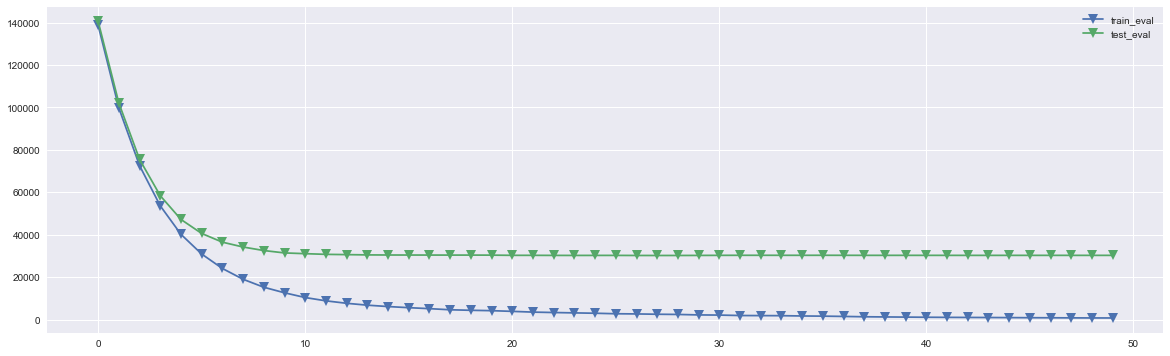

In [40]:
rmse_train = eval_history['train']['rmse']
rmse_test = eval_history['test']['rmse']

plt.figure(figsize=(20,6))
plt.plot(rmse_train,ms=10,marker='v',label='train_eval')
plt.plot(rmse_test,ms=10,marker='v',label='test_eval')
plt.legend()
plt.show()

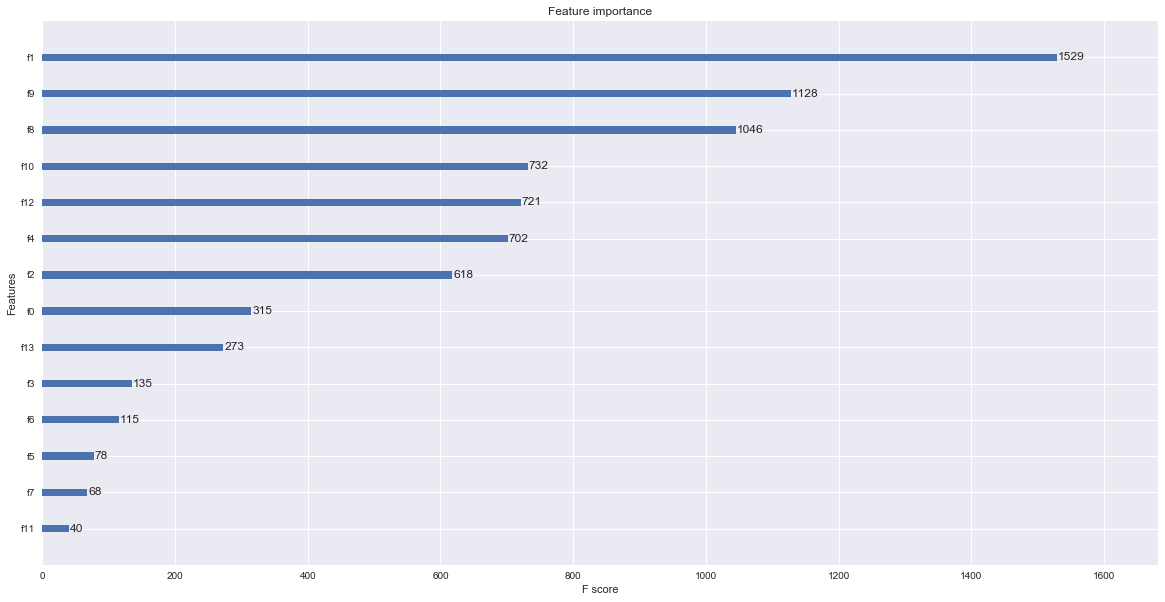

In [41]:
fig,ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(model,ax = ax)
plt.show()

## Select Model and output

In [ ]:
# model
param = {}
param['objective'] = 'reg:linear' # linear regression
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
num_round = 50
eval_list  = [(data_train,'train')]
eval_history = {}

# modeling
model = xgb.train( param, data_train, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)

predy = model.predict(data_test)

test_summition = pd.read_csv('C:/Users/Student/Downloads/Kaggle/test.csv')
test_summition = pd.DataFrame({'Id':test_summition['Id'],'SalePrice':pd.Series(predy)})
test_summition.shape


test_summition.to_csv('C:/Users/Student/Downloads/Kaggle/test_summition.csv')